# Code to train a different classification models on a custom dataset

### Total files for training: 24553
- 7028 Compliant
- 17525 Non-compliant

### Total files for validation: 6139
- 1757 Compliant
- 4382 Non-compliant

### Total files for testing: 18545
- 4795 Compliant
- 13750 Non-compliant

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jun 24 02:39:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/TESIS/Datasets/FMLD_dataset/para_entrenar/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:886: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


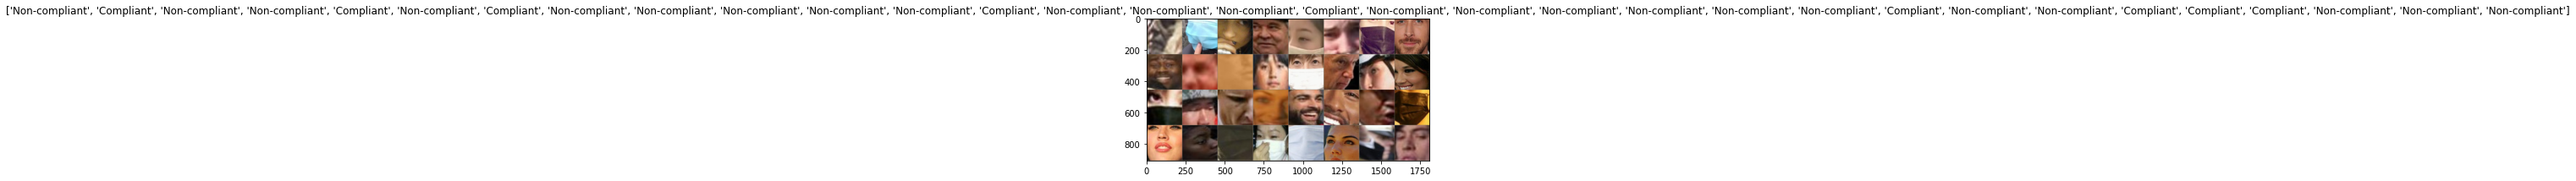

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [ ]:
model_ft = torch.hub.load('pytorch/vision:v0.9.0', 'resnet152', pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


## Get the model 

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=15)

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.0083 Acc: 0.8972
val Loss: 0.0073 Acc: 0.9052

Epoch 1/14
----------
train Loss: 0.0067 Acc: 0.9175
val Loss: 0.0046 Acc: 0.9458

Epoch 2/14
----------
train Loss: 0.0055 Acc: 0.9342
val Loss: 0.0042 Acc: 0.9464

Epoch 3/14
----------
train Loss: 0.0053 Acc: 0.9373
val Loss: 0.0030 Acc: 0.9645

Epoch 4/14
----------
train Loss: 0.0050 Acc: 0.9419
val Loss: 0.0027 Acc: 0.9661

Epoch 5/14
----------
train Loss: 0.0047 Acc: 0.9452
val Loss: 0.0033 Acc: 0.9593

Epoch 6/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


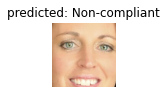

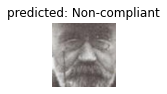

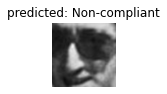

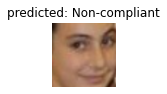

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


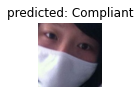

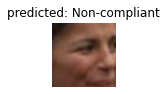

In [ ]:
visualize_model(model_ft)

## Save the complete model 

In [ ]:
torch.save(model_ft, 'resnet-152-Cross_Adam.pt')

In [ ]:
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Copy the model to drive

In [ ]:
!cp /content/resnet-152-Cross_Adam.pt /content/drive/MyDrive/TESIS/pesos_custom_dataset/OptimizersVsLoss/

## Making predictions 

In [ ]:
!find /content/crops/Non-compliant/ -iname .ipynb_checkpoints

Classes:  {0: 'Compliant', 1: 'Non-compliant'}
Number of faces:  6
Compliant


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


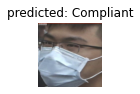

Compliant


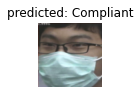

Compliant


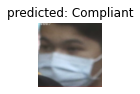

Compliant


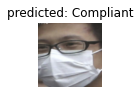

Non-compliant


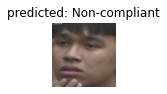

Non-compliant


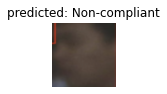

Test accuracy : 1.0


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 31 22:57:43 2020
@author: borut batagelj
"""

import os

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch import nn

import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np 

###
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
####



# Applying Transforms to the Data
image_transforms = { 
    'test': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Load the Data
''' dataset = 'faces'
test_directory = os.path.join(dataset, 'test') '''
test_directory="/content/drive/MyDrive/WORK/TEST_PAPER"

# Batch size
bs = 128

# Number of classes
num_classes = 2

# Load Data from folders
data = {
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test']),
}

class_names = data['test'].classes
transform=image_transforms['test']


# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['test'].class_to_idx.items()}
print('Classes: ',idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=False)

# Print the test set data sizes
print('Number of faces: ',test_data_size)

def computeTestSetAccuracy(model, loss_criterion, data_loader, data_size):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    test_acc = 0.0
    test_loss = 0.0

    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    # Validation - No gradient tracking needed
    with torch.no_grad():
        # Set to evaluation mode
        #model.eval()
        

        # Validation loop
        for j, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            #loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            #test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            for k in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(data_size//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[predictions[k]]))
                print(class_names[predictions[k]])
                imshow(inputs.cpu().data[k])

            
    # Find average test loss and test accuracy
    #avg_test_loss = test_loss/data_size
    avg_test_acc = test_acc/data_size
    return avg_test_acc



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_func = nn.CrossEntropyLoss() #for a multi-class classification problem 
  
model_file = '/content/drive/MyDrive/TESIS/pesos_custom_dataset/OptimizersVsLoss/resnet-34-Cross_Adagrad.pt'
if os.path.exists(model_file):    
    model = torch.load(model_file)
    model = model.to(device)
    avg_test_acc=computeTestSetAccuracy(model, loss_func, test_data_loader, test_data_size)
    print("Test accuracy : " + str(avg_test_acc))
else:
    print("Warrning: No Pytorch model for classification: resnet152.pt. Please Download it from GitHub link.\n")

## Without load the model

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 31 22:57:43 2020
@author: borut batagelj
"""

import os

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch import nn

import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np 

###
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
####



# Applying Transforms to the Data
image_transforms = { 
    'test': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Load the Data
''' dataset = 'faces'
test_directory = os.path.join(dataset, 'test') '''
test_directory="/content/drive/MyDrive/TESIS/Datasets/FMLD_dataset/definitivo/test/"

# Batch size
bs = 128

# Number of classes
num_classes = 2

# Load Data from folders
data = {
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test']),
}

class_names = data['test'].classes
transform=image_transforms['test']


# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['test'].class_to_idx.items()}
print('Classes: ',idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=False)

# Print the test set data sizes
print('Number of faces: ',test_data_size)

def computeTestSetAccuracy(model, loss_criterion, data_loader, data_size):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    test_acc = 0.0
    test_loss = 0.0

    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    # Validation - No gradient tracking needed
    with torch.no_grad():
        # Set to evaluation mode
        #model.eval()
        

        # Validation loop
        for j, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            #loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            #test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            ''' for k in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(data_size//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[predictions[k]]))
                print(class_names[predictions[k]])
                imshow(inputs.cpu().data[k]) '''

            
    # Find average test loss and test accuracy
    #avg_test_loss = test_loss/data_size
    avg_test_acc = test_acc/data_size
    return avg_test_acc



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_func = nn.CrossEntropyLoss() #for a multi-class classification problem 
  
model=model_ft
model = model.to(device)
avg_test_acc=computeTestSetAccuracy(model, loss_func, test_data_loader, test_data_size)
print("Test accuracy : " + str(avg_test_acc))


Classes:  {0: 'Compliant', 1: 'Non-compliant'}
Number of faces:  18545
Test accuracy : 0.953518468570632


<Figure size 432x288 with 0 Axes>

## To remove .ipynb_checkpoints 

In [ ]:
!find /content/test/ -iname .ipynb_checkpoints

/content/test/.ipynb_checkpoints


In [ ]:
!rm -r /content/test/.ipynb_checkpoints

In [ ]:
!find /content/drive/MyDrive/TESIS/Datasets/FMLD_dataset/para_entrenar -iname .ipynb_checkpoints

# Intento con ResNeST

In [ ]:
!pip install git+https://github.com/facebookresearch/fvcore.git

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-j4xfccqw
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-j4xfccqw
     |████████████████████████████████| 645kB 27.6MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5-cp37-none-any.whl size=64231 sha256=e64773b3f3f86c292de2eeb7ed822583e4a8ac34e3c7e9728f267821da46ced7
  Stored in directory: /tmp/pip-ephem-wheel-cache-3lbiq6ag/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
Successfully built fvcore
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
# get list of models
torch.hub.list('zhanghang1989/ResNeSt', force_reload=True)
# load pretrained models, using ResNeSt-50 as an example
model = torch.hub.load('zhanghang1989/ResNeSt', 'resnest101', pretrained=True)
model.eval()

Downloading: "https://github.com/zhanghang1989/ResNeSt/archive/master.zip" to /root/.cache/torch/hub/master.zip
Using cache found in /root/.cache/torch/hub/zhanghang1989_ResNeSt_master
Downloading: "https://github.com/zhanghang1989/ResNeSt/releases/download/weights_step1/resnest101-22405ba7.pth" to /root/.cache/torch/hub/checkpoints/resnest101-22405ba7.pth


ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): SplAtConv2d(
        (conv): Con

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/TESIS/Datasets/FMLD_dataset/para_entrenar/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4, drop_last=True )
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:886: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary

In [ ]:
model_ft = torch.hub.load('zhanghang1989/ResNeSt', 'resnest101', pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Using cache found in /root/.cache/torch/hub/zhanghang1989_ResNeSt_master


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=15)


Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.0052 Acc: 0.9357
val Loss: 0.0018 Acc: 0.9751

Epoch 1/14
----------
train Loss: 0.0033 Acc: 0.9614
val Loss: 0.0014 Acc: 0.9795

Epoch 2/14
----------
train Loss: 0.0027 Acc: 0.9673
val Loss: 0.0011 Acc: 0.9845

Epoch 3/14
----------
train Loss: 0.0024 Acc: 0.9719
val Loss: 0.0010 Acc: 0.9844

Epoch 4/14
----------
train Loss: 0.0021 Acc: 0.9753
val Loss: 0.0011 Acc: 0.9816

Epoch 5/14
----------
train Loss: 0.0020 Acc: 0.9776
val Loss: 0.0008 Acc: 0.9860

Epoch 6/14
----------


## Saving the model

In [ ]:
torch.save(model_ft, 'resnest-101_15_epochs_pretained.pt')

## Saving the model to drive 

In [ ]:
!cp /content/resnest-101_15_epochs_pretained.pt /content/drive/MyDrive/TESIS/pesos_custom_dataset/15_epochs/

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


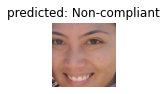

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


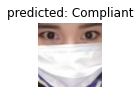

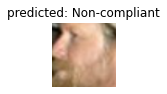

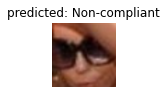

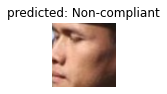

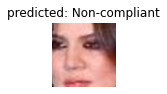

In [ ]:
visualize_model(model_ft)

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 31 22:57:43 2020
@author: borut batagelj
"""

import os

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch import nn

import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np 

###
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
####



# Applying Transforms to the Data
image_transforms = { 
    'test': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Load the Data
''' dataset = 'faces'
test_directory = os.path.join(dataset, 'test') '''
test_directory="/content/drive/MyDrive/TESIS/Datasets/FMLD_dataset/definitivo/test"

# Batch size
bs = 128

# Number of classes
num_classes = 2

# Load Data from folders
data = {
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test']),
}

class_names = data['test'].classes
transform=image_transforms['test']


# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['test'].class_to_idx.items()}
print('Classes: ',idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=False)

# Print the test set data sizes
print('Number of faces: ',test_data_size)

def computeTestSetAccuracy(model, loss_criterion, data_loader, data_size):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    test_acc = 0.0
    test_loss = 0.0

    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    # Validation - No gradient tracking needed
    with torch.no_grad():
        # Set to evaluation mode
        #model.eval()
        

        # Validation loop
        for j, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            #loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            #test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            """for k in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(data_size//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[predictions[k]]))
                print(class_names[predictions[k]])
                imshow(inputs.cpu().data[k])"""

            
    # Find average test loss and test accuracy
    #avg_test_loss = test_loss/data_size
    avg_test_acc = test_acc/data_size
    return avg_test_acc



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_func = nn.CrossEntropyLoss() #for a multi-class classification problem 

# Load the model from drive
model_file = '/content/drive/MyDrive/TESIS/pesos_custom_dataset/resnest-200_10_epochs_pretained.pt'
model=torch.load(model_file)  
#model=model_ft
model = model.to(device)
avg_test_acc=computeTestSetAccuracy(model, loss_func, test_data_loader, test_data_size)
print("Test accuracy : " + str(avg_test_acc))

Classes:  {0: 'Compliant', 1: 'Non-compliant'}
Number of faces:  18545
Test accuracy : 0.9610137504527241


<Figure size 432x288 with 0 Axes>

In [ ]:
torch.save(model_ft, 'resNeSt50_2_epochs_pretrained.pt')

In [ ]:
!cp /content/resNeSt50_2_epochs_pretrained.pt /content/drive/MyDrive/TESIS/pesos_custom_dataset/

## Intento con EfficientNet

In [ ]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=0c071e5f5467b528bcb183b27f912269c30acbdb208ce755a5bb50082a6748bb
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/TESIS/Datasets/FMLD_dataset/para_entrenar/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4, drop_last=True )
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:886: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary

In [ ]:
from efficientnet_pytorch import EfficientNet
model_ft = EfficientNet.from_pretrained('efficientnet-b4')
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Loaded pretrained weights for efficientnet-b4


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=15)

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.0310 Acc: 0.8983
val Loss: 0.0041 Acc: 0.9783

Epoch 1/14
----------
train Loss: 0.0079 Acc: 0.9539
val Loss: 0.0032 Acc: 0.9790

Epoch 2/14
----------
train Loss: 0.0070 Acc: 0.9591
val Loss: 0.0026 Acc: 0.9840

Epoch 3/14
----------
train Loss: 0.0063 Acc: 0.9638
val Loss: 0.0024 Acc: 0.9834

Epoch 4/14
----------
train Loss: 0.0056 Acc: 0.9676
val Loss: 0.0023 Acc: 0.9853

Epoch 5/14
----------
train Loss: 0.0052 Acc: 0.9702
val Loss: 0.0024 Acc: 0.9853

Epoch 6/14
----------
train Loss: 0.0047 Acc: 0.9731
val Loss: 0.0021 Acc: 0.9868

Epoch 7/14
----------
train Loss: 0.0047 Acc: 0.9734
val Loss: 0.0021 Acc: 0.9862

Epoch 8/14
----------
train Loss: 0.0049 Acc: 0.9722
val Loss: 0.0021 Acc: 0.9863

Epoch 9/14
----------
train Loss: 0.0047 Acc: 0.9725
val Loss: 0.0021 Acc: 0.9873

Epoch 10/14
----------
train Loss: 0.0046 Acc: 0.9746
val Loss: 0.0021 Acc: 0.9862

Epoch 11/14
----------
train Loss: 0.0048 Acc: 0.9728
val Loss: 0.0021 Acc: 0.9866

Epoch 12/14
----------
t

In [ ]:
torch.save(model_ft, 'efficientnet-b4_15_epochs_pretrained.pt')

In [ ]:
!cp /content/efficientnet-b4_15_epochs_pretrained.pt /content/drive/MyDrive/TESIS/pesos_custom_dataset/15_epochs/

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 31 22:57:43 2020
@author: borut batagelj
"""

import os

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch import nn

import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np 

###
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
####



# Applying Transforms to the Data
image_transforms = { 
    'test': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Load the Data
''' dataset = 'faces'
test_directory = os.path.join(dataset, 'test') '''
test_directory="/content/drive/MyDrive/TESIS/Datasets/FMLD_dataset/definitivo/test"

# Batch size
bs = 128

# Number of classes
num_classes = 2

# Load Data from folders
data = {
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test']),
}

class_names = data['test'].classes
transform=image_transforms['test']


# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['test'].class_to_idx.items()}
print('Classes: ',idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=False)

# Print the test set data sizes
print('Number of faces: ',test_data_size)

def computeTestSetAccuracy(model, loss_criterion, data_loader, data_size):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    test_acc = 0.0
    test_loss = 0.0

    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    # Validation - No gradient tracking needed
    with torch.no_grad():
        # Set to evaluation mode
        #model.eval()
        

        # Validation loop
        for j, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            #loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            #test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            """for k in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(data_size//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[predictions[k]]))
                print(class_names[predictions[k]])
                imshow(inputs.cpu().data[k])"""

            
    # Find average test loss and test accuracy
    #avg_test_loss = test_loss/data_size
    avg_test_acc = test_acc/data_size
    return avg_test_acc



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_func = nn.CrossEntropyLoss() #for a multi-class classification problem 

# Load the model from drive
model_file = '/content/drive/MyDrive/TESIS/pesos_custom_dataset/10_epochs/efficientnet-b4_10_epochs_pretrained.pt'
model=torch.load(model_file)  
#model=model_ft
model = model.to(device)
avg_test_acc=computeTestSetAccuracy(model, loss_func, test_data_loader, test_data_size)
print("Test accuracy : " + str(avg_test_acc))

Classes:  {0: 'Compliant', 1: 'Non-compliant'}
Number of faces:  18545
Test accuracy : 0.9554596926877363


<Figure size 432x288 with 0 Axes>